In [1]:
import torch
import math
import numpy as np

import torch.nn as nn

from sklearn.cluster import KMeans
import numpy as np

class GMM(nn.Module):
    
    
    def __init__(self, K, D):
        """
        Initializes means, variances and weights randomly
        :param K: number of gaussians
        :param D: number of features
        """
        super(GMM, self).__init__()

        self.D = D
        self.K = K
        self.mu = nn.Parameter(torch.rand(K, D))
        self.logvar = nn.Parameter(torch.rand(K))
        self.alpha = nn.Parameter(torch.empty(K).fill_(1. / K))

        self.logvarbound = 0
        self.NORM_CONST = torch.tensor(2*math.pi).log()
    
    def forward(self, X):
        """
        Compute the likelihood of each data point under each gaussians.
        :param X: design matrix (examples, features) (N,D)
        :return likelihoods: (K, examples) (K, N)
        """
        
        a = ((X[None,:,:]-self.mu[:,None,:])**2).sum(-1)
        b = self.logvar[:,None].exp()
        return (self.alpha.log()[:,None] 
                - .5*( self.D*self.NORM_CONST 
                      + self.D*self.logvar[:,None] 
                      + a/b ) )
                                          
    
    def get_posteriors(self, X):
        log_like = self.forward(X)
        log_post = log_like - self.logsumexp(log_like, dim=0, keepdim=True)
        return log_post
    
    def EM_step(self, X):
        log_post = self.get_posteriors(X)
        post = log_post.exp()
        Nk = post.sum(dim=1)
        
        self.mu.data = (post[:,:,None]*X[None,:,:]).sum(dim=1) / Nk[:,None]
        temp = log_post + ((X[None,:,:]-self.mu[:,None,:])**2).sum(dim=-1).log()
        self.logvar.data = (- Nk.log() 
                       + self.logsumexp(temp, dim=1, keepdim=False))
        
        self.alpha.data = Nk/Nk.sum()
        
    def find_solution(self, X, initialize=True, iterate=True):
        
        assert X.device==self.mu.device, 'Data stored on ' + str(X.device) + ' but model on ' + str(self.mu.device)
        
        with torch.no_grad():
            if initialize:
                m = X.size(0)
                idxs = torch.from_numpy(np.random.choice(m, self.K, replace=False)).long()
                self.mu.data = X[idxs]
                
                # find variance within its cluster
                kmeans = KMeans(n_clusters=self.K, random_state=0, max_iter=300).fit(X.cpu())
                #index = kmeans.predict(X_MNIST.cpu())
                self.mu.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float, device=self.mu.device)
                index = (X[:,None,:]-torch.tensor(self.mu.data[None,:,:], dtype=torch.float)).norm(dim=2).min(dim=1)[1]
                for i in range(self.K):
                    assert (index==i).sum()>0, 'Empty cluster'
                    self.alpha.data[i] = (index==i).float().sum() / self.K
                    temp = (X_MNIST[index==i,:] -self.mu.data[i,:]).norm(dim=1).mean()
                    if temp < 0.00001:
                        temp = torch.tensor(1.)
                    self.logvar.data[i] = temp.log() * 2

                
                #self.logvar.data = torch.empty(self.K, device=self.mu.device).fill_( (X.var() / self.K).log() ) + 6
                #self.alpha.data = torch.empty(self.K, device=self.mu.device).fill_(1. / self.K)
                self.logvarbound = (X.var() / m).log()

            if iterate:
                for _ in range(500):
                    mu_prev = self.mu
                    logvar_prev = self.logvar
                    alpha_prev = self.alpha
                    self.EM_step(X)
                    self.logvar.data[self.logvar < self.logvarbound] = self.logvarbound

                    delta = torch.stack( ((mu_prev-self.mu).abs().max(),
                                (logvar_prev-self.logvar).abs().max(),
                                (alpha_prev-self.alpha).abs().max()) ).max()

                    if delta<10e-6:
                        break

    
    @staticmethod
    def logsumexp(x, dim, keepdim=False):
        """
        :param x: input data
        :param dim: dimension to sum over
        :param keepdim: whether it should squeeze that dimension
        :return:
        """
        max, _ = torch.max(x, dim=dim, keepdim=True)
        out = max.squeeze() + (x - max).exp().sum(dim=dim, keepdim=keepdim).log()
        return out

    

In [2]:
def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

# generate some clusters
cluster1 = sample(
    torch.Tensor([2.5, 2.5]),
    torch.Tensor([1.2, .8]),
    nb_samples=500
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5]),
    nb_samples=500
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8]),
    nb_samples=1000
)

X = torch.cat([cluster1, cluster2, cluster3])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#gmm = GMM(100, 2).to(device)
#gmm.find_solution(X.to(device))

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
#import seaborn as sns
from matplotlib import patches

def plot_2d_sample(sample, mu=None, sig=None, idx=(0,1)):
    """
    :param sample: 
    :param mu:
    :param sig: 
    :return:
    """
    #fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.cla()
    
    sample_np = sample.numpy()
    x = sample_np[:, idx[0]]
    y = sample_np[:, idx[1]]
    ax.scatter(x, y)

    if (mu is not None and sig is not None):
        for i in range(mu.shape[0]):
            ellipse = patches.Ellipse( (mu[i,idx[0]], mu[i,idx[1]]) , 2*sig[i], 2*sig[i], color='r', fill=False) 
            ax.add_artist(ellipse)
    plt.axis('equal')
    plt.show()

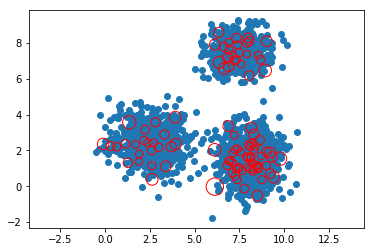

In [6]:
plot_2d_sample(X,gmm.mu, (gmm.logvar/2).exp())

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, base_model, X, K, loglam):
        super(Net, self).__init__()
        self.base_model = base_model
        
        self.gmm = GMM(K, 784)
        self.gmm.find_solution(X, iterate=False)
        #self.log_pz_lam = -784*torch.tensor(i).log().to(device)
        self.log_pz_lam = nn.Parameter(torch.tensor(loglam, dtype=torch.float))
        self.log_K = -torch.tensor(10.).log()
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        likelihood_per_peak = self.gmm(x.view(batch_size, 784))
        like = self.gmm.logsumexp(likelihood_per_peak, 0)

        x = self.base_model(x)
        
        a1 = torch.stack( (x + like[:,None], (self.log_pz_lam + self.log_K)*torch.ones_like(x) ), 0)
        b1 = self.gmm.logsumexp(a1, 0).squeeze()

        a2 = torch.stack( (like , (self.log_pz_lam)*torch.ones_like(like) ), 0)
        b2 = self.gmm.logsumexp(a2, 0).squeeze()[:,None]

        return b1-b2


class NetVanilla(nn.Module):
    def __init__(self):
        super(NetVanilla, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
from torchvision import datasets, transforms

batch_size = 100
test_batch_size = 10


class Transpose(object):
    def __init__(self):
        pass
    def __call__(self, data):
        return data.transpose(-1,-2)

transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

transform = transforms.ToTensor()

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=False)
gmm_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=3000, shuffle=True)

#EMNIST is rotated 90 degrees from MNIST
EMNIST_train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='letters', download=True, train=True, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=batch_size, shuffle=True)

EMNIST_test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='letters', download=True, train=False, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=test_batch_size, shuffle=True)

EMNIST_test_loader_digits = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='digits', download=True, train=False, 
                    transform=transforms.Compose([transform, Transpose()])),
    batch_size=test_batch_size, shuffle=True)

X_MNIST = enumerate(gmm_loader).__next__()[1][0].view(gmm_loader.batch_size, 784)

In [182]:
def train_vanilla(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train(model, device, train_loader, optimizer, epoch, adv_loader, verbose=True):
    model.train()
    min_loss = torch.tensor(10.).log()
    #for batch_idx, (data, target) in enumerate(train_loader):
    for ((batch_idx, (data, target)), (_, (data_adv, _))) in zip(enumerate(train_loader),enumerate(adv_loader)):
        data, target = data.to(device), target.to(device)
        data_adv = data_adv.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        input_rand = torch.rand(train_loader.batch_size,1,28,28).to(device)
        #output_rand = model(input_rand)
        output_rand = model(data_adv)

        loss = F.nll_loss(output, target) - output_rand.sum()/(10*train_loader.batch_size)
        loss.backward()
        return
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))
    
def test_adv(model, device, adv_test_loader):
    model.eval()
    av_conf = 0
    with torch.no_grad():
        for data, _ in adv_test_loader:
            data = data.to(device)
            output = model(data)

            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            av_conf += c.exp().sum().item()
            
    av_conf /= len(adv_test_loader.dataset)

    print('\nAve. Confidence: {:.0f}%\n'.format(100.*av_conf))

In [191]:
base_model = NetVanilla().to(device)

In [ ]:
import torch.optim as optim

lr = .001
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum)
for epoch in range(10):
    train_vanilla(base_model, device, train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303018
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.277459
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.174838
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.878243
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.006571
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.462244
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.466167
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.366389
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.300985
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.302273
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.284910
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.239428
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.188113
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.375859
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.208659
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.239339
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.119820
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.246846
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.153552
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.157912
Train Epoch: 3 [2000

In [ ]:
model = Net(base_model, X_MNIST, 700, -765).to(device)

In [ ]:
#model.log_pz_lam = torch.tensor(-770., device=device)

data = enumerate(EMNIST_test_loader_digits).__next__()[1][0]
y = model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

y = base_model(data.to(device))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item())
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

#model.log_pz_lam = torch.tensor(-763., device=device)
test(model, device, test_loader)
test(base_model, device, test_loader)

test_adv(model, device, EMNIST_test_loader)
test_adv(base_model, device, EMNIST_test_loader)

In [ ]:
lr = .00001
momentum = .9

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
for epoch in range(2):
    train(model, device, train_loader, optimizer, epoch, EMNIST_train_loader)

In [ ]:
data = enumerate(EMNIST_test_loader_digits).__next__()[1][0]
y = model(data.to(device))
y_base = base_model(data.to(device))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y_base.argmax(1)[i].item()) + ":   %.2f" % y_base[i].max().exp().item()
              +'\n'
              +str(y.argmax(1)[i].item()) + ":   %.2f" % y[i].max().exp().item()
             )
    plt.imshow(data[i].squeeze(), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

test(model, device, test_loader)
test(base_model, device, test_loader)

test_adv(model, device, EMNIST_test_loader)
test_adv(base_model, device, EMNIST_test_loader)

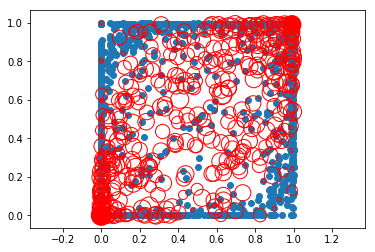

In [164]:
plot_2d_sample(X_MNIST,model.gmm.mu, (model.gmm.logvar/2).exp()/100,idx=(345,346))

In [104]:
like = model.gmm.eval()(X_MNIST[:50].to(device))

In [105]:
like.shape

torch.Size([700, 50])

In [106]:
model.gmm.logsumexp(like, dim=0)

tensor([-758.0963, -757.1808, -754.4064, -756.9949, -766.0916, -769.0267,
        -752.5599, -757.5797, -757.6455, -726.9989, -754.8010, -758.5550,
        -758.1229, -756.3209, -757.8757, -763.3907, -757.2258, -762.3088,
        -754.4244, -765.7964, -756.5364, -756.6391, -761.6033, -764.0020,
        -759.7390, -752.0950, -763.9653, -757.2697, -764.6464, -759.5300,
        -766.1407, -763.0562, -763.3931, -755.2834, -755.2457, -759.6354,
        -758.4511, -753.3654, -764.0854, -752.3019, -758.0759, -747.3070,
        -760.4293, -755.1789, -759.6160, -752.6479, -760.0718, -745.7424,
        -761.5190, -757.7358], device='cuda:0', grad_fn=<AddBackward0>)

In [103]:
X_MNIST[:100].shape

torch.Size([100, 784])

In [18]:
like_E = model.gmm.eval()(data.view(10,784).to(device))

In [20]:
model.gmm.logsumexp(like_E, dim=0).mean()

tensor(-767.1601, device='cuda:0', grad_fn=<MeanBackward1>)

In [26]:
model.log_pz_lam -= 763.

In [27]:
model.log_pz_lam

tensor(-763., device='cuda:0')